In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)


In [3]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data("/kaggle/input/svhndataset/train_32x32.mat")
X_test, y_test = load_data("/kaggle/input/svhndataset/test_32x32.mat")

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


In [4]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

In [5]:
print("Training Set", X_train.shape)
print("Test Set", X_test.shape)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)


In [6]:
X_train.shape

(73257, 32, 32, 3)

In [7]:
y_train.shape

(73257,)

In [8]:
y_train[0]

1

In [9]:
X_train[0].shape

(32, 32, 3)

In [13]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0


In [14]:
# Replace label '10' with '0'
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,      # Randomly rotate images in the range (degrees)
    zoom_range=0.1,         # Randomly zoom image
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    horizontal_flip=False   # Set to False for digit classification
)

# Fit the generator to the training data
datagen.fit(X_train)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# Build the CNN model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=10, activation='softmax'))  # 10 classes for digits 0-9

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,930 (835.66 KB)

 Trainable params: 212,266 (829.16 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [18]:
# Set training parameters
batch_size = 64
epochs = 20

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test))


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1144/1144 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.1606 - loss: 3.0920 - val_accuracy: 0.5053 - val_loss: 1.4366
Epoch 2/20
   1/1144 ━━━━━━━━━━━━━━━━━━━━ 2:16 119ms/step - accuracy: 0.3594 - loss: 1.9556

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1144/1144 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3594 - loss: 1.9556 - val_accuracy: 0.5063 - val_loss: 1.4337
Epoch 3/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 173s 151ms/step - accuracy: 0.4086 - loss: 1.8840 - val_accuracy: 0.7468 - val_loss: 0.8068
Epoch 4/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5312 - loss: 1.7800 - val_accuracy: 0.7471 - val_loss: 0.8061
Epoch 5/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 174s 151ms/step - accuracy: 0.5556 - loss: 1.3936 - val_accuracy: 0.8272 - val_loss: 0.5829
Epoch 6/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7031 - loss: 1.0322 - val_accuracy: 0.8268 - val_loss: 0.5831
Epoch 7/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 173s 151ms/step - accuracy: 0.6459 - loss: 1.1020 - val_accuracy: 0.8606 - val_loss: 0.4750
Epoch 8/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6562 - loss: 0.9907 - val_accuracy: 0.8605 - val_loss: 0.4744
Epoch 9/20
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 174s 152ms/step - accuracy: 0.7108 - lo

In [20]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9092


In [21]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


814/814 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step


In [22]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true_classes, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1744
           1       0.94      0.94      0.94      5099
           2       0.93      0.94      0.93      4149
           3       0.87      0.89      0.88      2882
           4       0.92      0.92      0.92      2523
           5       0.88      0.93      0.90      2384
           6       0.89      0.87      0.88      1977
           7       0.94      0.91      0.93      2019
           8       0.94      0.82      0.88      1660
           9       0.82      0.87      0.84      1595

    accuracy                           0.91     26032
   macro avg       0.90      0.90      0.90     26032
weighted avg       0.91      0.91      0.91     26032



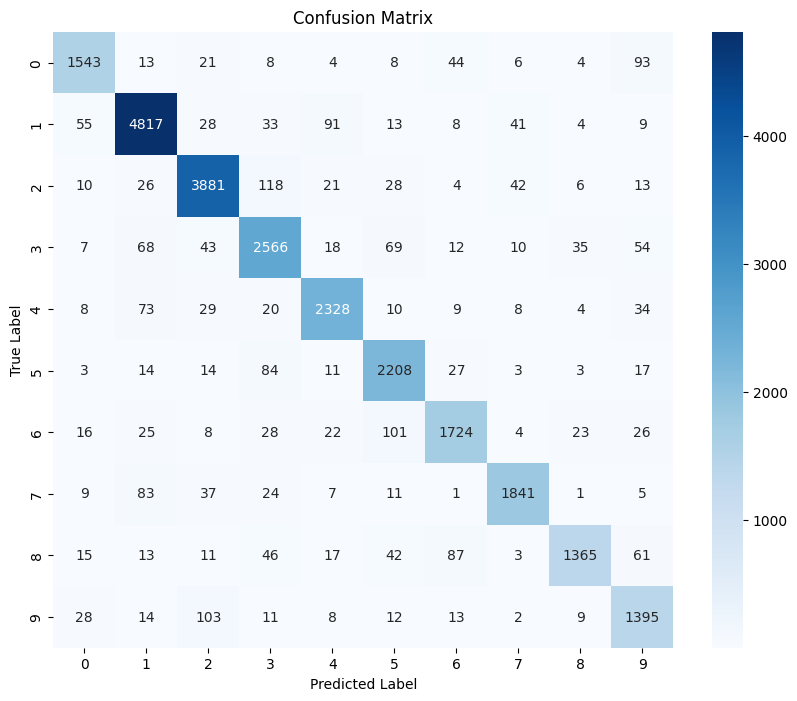

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9092
Precision: 0.9100
Recall: 0.9092
F1-Score: 0.9092


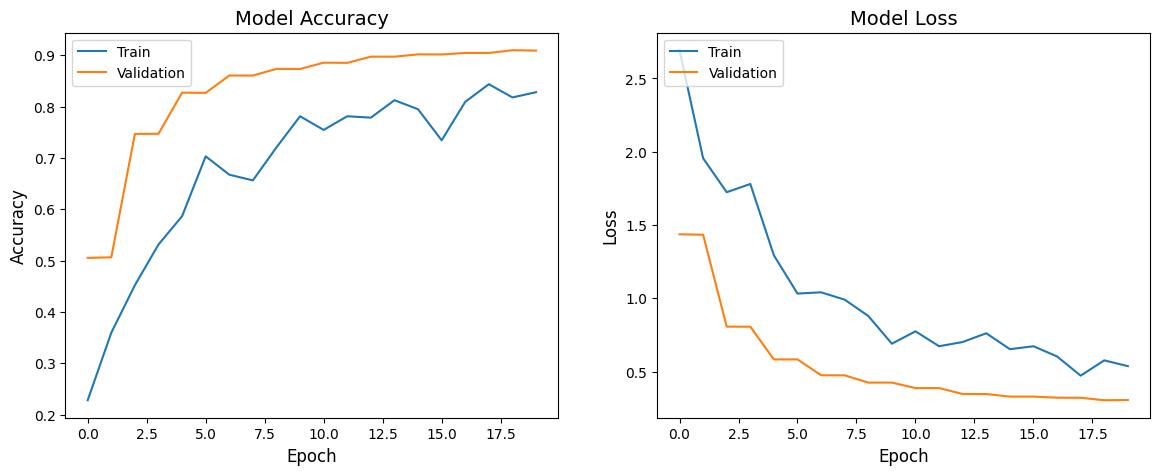

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [29]:
# Save the model
model.save('svhn_cnn_model.h5')

# To load the model later
# from tensorflow.keras.models import load_model
# model = load_model('svhn_cnn_model.h5')
